# Adapt Dataset

This notebook contains the steps to adapt the original dataset ([Cyclist Dataset for Object Recognition](https://www.kaggle.com/datasets/semiemptyglass/cyclist-dataset)), and make it usable for our project. 

This notebook can't be run again on our new version of the dataset, as it was used to change the dataset format. We downloaded the [dataset](https://www.kaggle.com/datasets/f445f341fc5e3ab58757efa983a38d6dc709de82abd1444c8817785ecd42a1ac), and saw that 1623 images out of 13 674 were not labeled. Thus, we removed these images, which gives a dataset of 12051 images. The label format could also not be used with the tensorflow object detection API. So we converted it into the VOC XML format. And then, we split the dataset into 3 sets : 90% train and 10% for test, and then 10% of the train data has been extracted to have a validation set. These manipulations necessited to manage folders and files with command lines. Before executing this notebook, the folder looked like this:
* `images/` contains 13 674 images
* `labels/` contains 13 674 .txt files (yolo bounding box format) with this format `id center_x center_y width height`

Now, the folder looks like this:
* `adapt_dataset.ipynb` this jupyter notebook
* `tensorflow-scripts/` contains the scripts from tensorflow
    * `partition_dataset.py` python script to split a folder of images with labels into 2 subfolders train and test
* `images/` contains the data
    * `train/` contains 9760 images and labels of the train set 
    * `test/` contains 1206 images and labels of the test set
    * `validation/` contains 1085 images and labels of the validation set

This notebook is used to keep track of every manipulations done to change the dataset format and split it into 3 sets. Now, we can explore the dataset. See [data_exploration.ipynb](data_exploration.ipynb).

To download the new version of the dataset, you can also directly follow the steps in *Setup-requirements* in the readme.

# Download the dataset

To download the dataset from kaggle with the kaggle api, you need to create a kaggle API token and place it in kaggle.json (follow these steps : [Kaggle API Credentials](https://github.com/Kaggle/kaggle-api#api-credentials)). You can also download manually the data from the website, and extract the zip folder in the current directory. Kaggle is protected against wget commands, so we can't use it to download the dataset. But the final version of the dataset (after executing all this notebook) can be download from a wget command by following the *Setup-requirements* section in the readme.

In [5]:
#!pip install kaggle

In [ ]:
# uncomment if used
#!kaggle datasets download -d semiemptyglass/cyclist-dataset

# Import the dataset, remove images without labels and convert the labels from YOLO format to VOC XML (format used by tensorflow)

In [ ]:
import random, os
#!pip install pylabel
from pylabel import importer

In [2]:
# Import dataset
img_dir = "data/images/"
label_dir = "data/labels/"

imgs = os.listdir(img_dir)
labels = os.listdir(label_dir)
imgs = sorted(imgs)
labels = sorted(labels)
display(len(imgs))

13674

In [3]:
# Count the number of images that don't have label :
cnt=0
for i,labelfile in enumerate(labels):
    with open(label_dir+labelfile,'r') as f:
        # If the label file is empty, increment the counter
        if(f.read()==""):
            cnt+=1
print(f"{cnt} images don't have a proper label.")

1623 images don't have a proper label.


In [4]:
# Remove images without labels that are useless for training our model
cnt=0
for i,labelfile in enumerate(labels):
    with open(label_dir+labelfile,'r') as f:
        # If the label file is empty, then remove the file and its associated image
        if(f.read()==""):
            os.remove(label_dir+labelfile)
            os.remove(img_dir+imgs[i])
            cnt+=1
            if(cnt%200==0):
                print(f"Removed {cnt} images and their empty labels")
                
print(f"Removed a total of {cnt} images and their empty labels.")

Removed 200 images and their empty labels
Removed 400 images and their empty labels
Removed 600 images and their empty labels
Removed 800 images and their empty labels
Removed 1000 images and their empty labels
Removed 1200 images and their empty labels
Removed 1400 images and their empty labels
Removed 1600 images and their empty labels
Removed a total of 1623 images and their empty labels.


In [5]:
# Re-read the files as we deleted some of them
imgs = os.listdir(img_dir)
labels = os.listdir(label_dir)
imgs = sorted(imgs)
labels = sorted(labels)

print(len(labels))

12051


In [6]:
# Now let's import the dataset with pylabel
path_labels = "data/labels/"
path_imgs = "data/images/"
classes = ['cyclist']
# Importing the dataset as a Dataset object from pylabel can take a few minutes
dataset = importer.ImportYoloV5(path="data/labels/",path_to_images="../../data/images/",cat_names=classes)

In [7]:
dataset.df.head(5)

,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_segmentation,ann_iscrowd,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,
0,../../data/images/,009809.jpg,,0,2048,1024,3,,412.0,349.0,...,,,,,,0,cyclist,,,1
1,../../data/images/,010669.jpg,,1,2048,1024,3,,1120.0,373.0,...,,,,,,0,cyclist,,,1
2,../../data/images/,010669.jpg,,1,2048,1024,3,,806.0,297.0,...,,,,,,0,cyclist,,,1
3,../../data/images/,010669.jpg,,1,2048,1024,3,,1664.0,324.0,...,,,,,,0,cyclist,,,1
4,../../data/images/,004203.jpg,,2,2048,1024,3,,1246.0,395.0,...,,,,,,0,cyclist,,,1


In [15]:
display(dataset.df["img_width"].unique())
display(dataset.df["img_height"].unique())
display(dataset.df["img_depth"].unique())

array([2048])

array([1024])

array([3])

All our images have a size of 2048x1024x3. More data exploration will be done after preparation of the dataset.

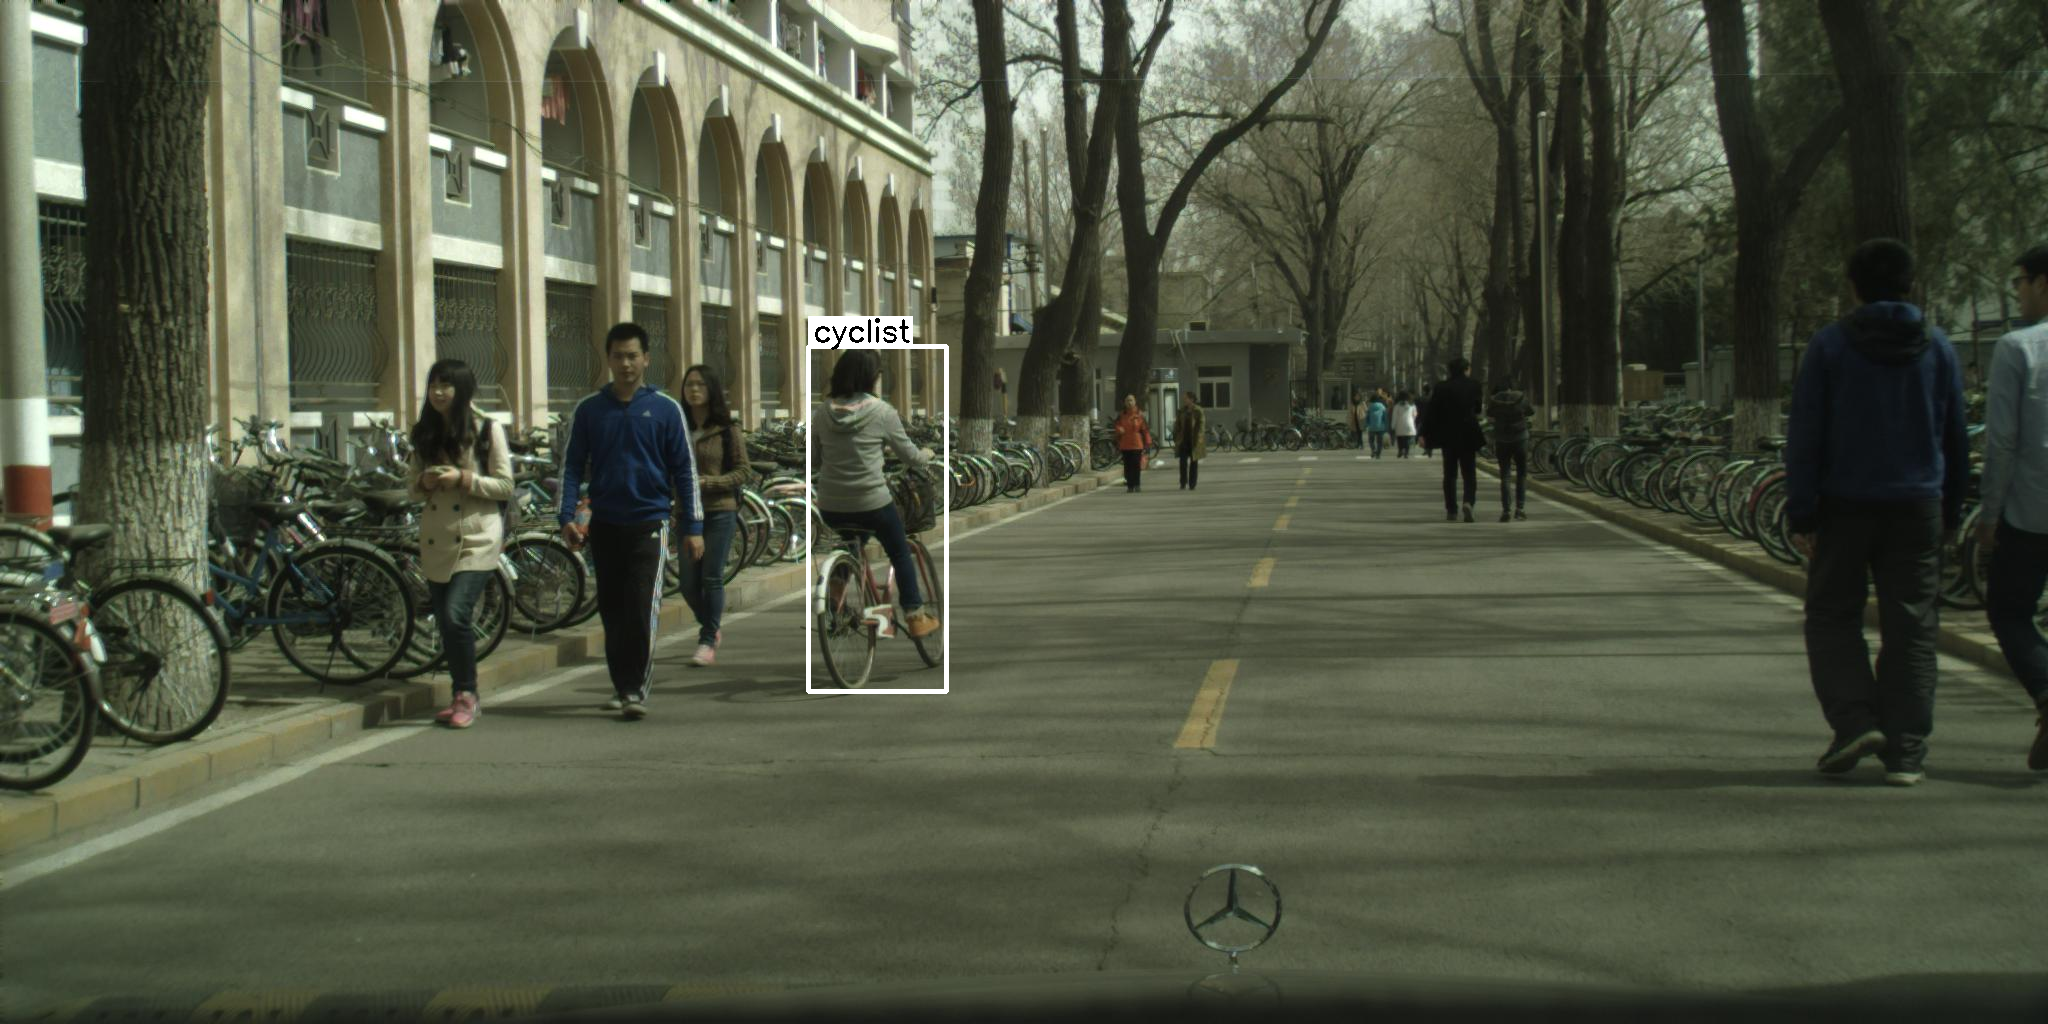

In [16]:
from IPython.display import Image, display
# Visualize a sample
display(dataset.visualize.ShowBoundingBoxes(21))

In [17]:
# export the labels to XML so we can use the dataset with tensorflow object detection API:
from pathlib import Path
import os
output_path = str(Path(dataset.path_to_annotations, "../", "voc_annotations/"))
# Create output folder
Path(output_path).mkdir(exist_ok=True)
# Export the labels into this folder
dataset.export.ExportToVoc(output_path=output_path)[0]

'data/labels/../voc_annotations/002150.xml'

Now the new labels are in the voc_annotations folder.

# Create train/test/val folders

In [ ]:
# Move the annotations into the image folder
!mv data/voc_annotations/* data/images/
# Delete the annotation folder
!rmdir data/voc_annotations/
# Delete the old label folder
!rm -rf data/labels

In [23]:
# Use the tensorflow script partition_dataset to split the data into train and test (90% for train and 10% for test)
!python3 tensorflow-scripts/partition_dataset.py -x -i data/images -r 0.1

tensorflow-scripts/partition_dataset.py:35: DeprecationWarning: Flags not at the start of the expression '([a-zA-Z0-9\\s_\\\\.\\-\\' (truncated)
  if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(?i)(.jpg|.jpeg|.png)$', f)]


In [24]:
# Now the folders train and test have been created into data/images so we can delete the images
# and labels in data/images
!rm data/images/*.jpg
!rm data/images/*.xml

In [35]:
train = os.listdir("data/images/train")
test = os.listdir("data/images/test")

# Divide by 2 because the folders also contains the labels
print( f"Size of train set: {len(train)/2}")
print( f"Size of test set: {len(test)/2}")

Size of train set: 10845.0
Size of test set: 1206.0


In [33]:
!mv data/images/trainval data/images/train

In [36]:
# Now create the validation set by taking 10% of the training set
!python3 tensorflow-scripts/partition_dataset.py -x -i data/images/train -r 0.1

tensorflow-scripts/partition_dataset.py:35: DeprecationWarning: Flags not at the start of the expression '([a-zA-Z0-9\\s_\\\\.\\-\\' (truncated)
  if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(?i)(.jpg|.jpeg|.png)$', f)]


In [43]:
# Move the validation folder at the same level as train and test
!mv data/images/train/test data/images/validation

In [44]:
# Remove the previous train images and labels
!rm data/images/train/*.jpg
!rm data/images/train/*.xml

In [45]:
# Move images from train/train into train/
!mv data/images/train/train/* data/images/train

In [46]:
# Remove the empty train folder
!rmdir data/images/train/train

In [47]:
# Check partition sizes:
train = os.listdir("data/images/train")
test = os.listdir("data/images/test")
val = os.listdir("data/images/validation")

# To get the size of each partition, we need to divide the length of these folder by 2 as each folder contains the 
# image file and the label file
print("Number of samples in the training set: " + str(int(len(train)/2)))
print("Number of samples in the validation set: " + str(int(len(val)/2)))
print("Number of samples in the test set: " + str(int(len(test)/2)))

Number of samples in the training set: 9760
Number of samples in the validation set: 1085
Number of samples in the test set: 1206


In [48]:
# Move images in the parent directory and remove the folder data/
!mv data/images/ .
!rmdir data

In [50]:
# Current state of the folder
!ls -l

total 3192
-rw-rw-r-- 1 clement clement 2585228 nov.  10 11:32 adapt_dataset.ipynb
-rw-rw-r-- 1 clement clement    2054 nov.  10 10:57 data_analysis.ipynb
drwxrwxr-x 5 clement clement  663552 nov.  10 11:33 images
-rw-rw-r-- 1 clement clement    4368 nov.  10 10:58 README.md
drwxrwxr-x 2 clement clement    4096 nov.   6 11:28 tensorflow-scripts


Now we are ready to use the dataset for our project!